In [1]:
# Import System packages
import sys 
import ROOT 
import glob 
import numpy as np 
import pandas as pd 
import array
import pandas as pd
import os
import cppyy
import matplotlib.pyplot as plt
import awkward as ak
import matplotlib.pyplot as plt
from tqdm import tqdm
import array
import uproot


# Load Custom Libraries
sys.path.insert(0,"/eos/user/t/tpeacock/Software/analysisTools/")
sys.path.insert(0,"/eos/user/t/tpeacock/Software/hk-BONSAI/python/")

import pyBONSAI
import pyWCTEAnalysisTools
from pyWCTEAnalysisTools import *

# Setup the default directories and create a BONSAI object
pyBONSAI.set_default_directories(
    WCSIM_BUILD_DIR="/eos/user/t/tpeacock/Software/WCSim-develop/build/",
    BONSAIDIR="/eos/user/t/tpeacock/Software/hk-BONSAI/",
    BONSAIPARAM="/eos/user/t/tpeacock/Software/hk-BONSAI/data/fit_param_wcte.dat"
)
bonsai = pyBONSAI.WCTE_hkBONSAI()

ImportError: Failed to import libcppyy3_9. Please check that ROOT has been built for Python 3.9

In [1]:
import uproot

cable_mapping_list = np.load("WCSIM_CABLE_MAP.npy")

class ReadoutWindow:
    def __init__(self):
        self.valid = False
        
def add_pmtindex(w):
    w.lookupids = w.hit_mpmt_slot_ids*100 + w.hit_pmt_position_ids
    

def add_cables(w):
    w.cables = cable_mapping_list[w.lookupids].astype(np.int32)+1
    
def getwindows(chunk, branches):
    nwindows = len(chunk[branches[0]])
    
    hit_pmt_has_time_constant = chunk["hit_pmt_has_time_constant"]
    hit_pmt_calibrated_times = chunk["hit_pmt_calibrated_times"]
        
    rwlist= []
    for i in range(nwindows):
        rw = ReadoutWindow()
        
        mask = hit_pmt_has_time_constant[i] > 0
        order = ak.argsort( hit_pmt_calibrated_times[i][mask] )

        for attr in branches:            
            setattr(rw, attr, chunk[attr][i][mask][order])
                
        rw.valid = True
        add_pmtindex(rw)
        add_cables(rw)
        
        rwlist.append(rw)
        
    return rwlist


def window_builder(gen):
 
    branches=[
        "hit_pmt_calibrated_times",
        "hit_pmt_has_time_constant",
        "hit_pmt_charges",
        "hit_pmt_channel_ids",
        "hit_pmt_position_ids",
        "hit_mpmt_slot_ids",
        "hit_mpmt_card_ids",
        "hit_pmt_channel_ids",
        "hit_pmt_position_ids"
    ]
    
    for item in gen:
        windows = getwindows(item, branches)
        yield windows
        

def iterate_readout_windows(filename, step_size, max_size=None):
    
    branches=[
        "hit_pmt_calibrated_times",
        "hit_pmt_has_time_constant",
        "hit_pmt_charges",
        "hit_pmt_channel_ids",
        "hit_pmt_position_ids",
        "hit_mpmt_slot_ids",
        "hit_mpmt_card_ids",
        "hit_pmt_channel_ids",
        "hit_pmt_position_ids"
    ]

    chunks = uproot.iterate(f"{filename}:WCTEReadoutWindows", 
                            branches, 
                            library="np", 
                            step_size=step_size)
    
    count = 0
    for windows in window_builder(chunks):
        count += step_size
        if max_size and count > max_size: break
        yield windows
        


def iterate_n50_windows(w,
                    nhits_min=0,
                    nhits_max=10000):
    
    startidx = 0
    endidx = 0
    
    mask = w.cables > 0
    w.hit_pmt_calibrated_times = w.hit_pmt_calibrated_times[mask]
    w.hit_pmt_charges = w.hit_pmt_charges[mask]
    w.cables = w.cables[mask]
    
    hittimes = w.hit_pmt_calibrated_times
    nmax = len(hittimes)
      
    windows = []
    i = 0
    while i < nmax:
        
        startidx = i
        starttime = hittimes[startidx]
        
        for j in range(i,nmax-1):
            endidx = j
            endtime = hittimes[endidx+1]
        
            if (endtime - starttime) > 50:
                break
        i += 1
        
        nhits = (endidx - startidx)
        if nhits > nhits_min and nhits < nhits_max:
            rwn = ReadoutWindow()
            rwn.hit_pmt_calibrated_times = hittimes[startidx:endidx]
            rwn.hit_pmt_charges = w.hit_pmt_charges[startidx:endidx]
            rwn.cables = w.cables[startidx:endidx]
            
            # Remove duplicated hits, getting the first one seen (not ideal).
            _, unique_indices = np.unique(rwn.cables, return_index=True)
            unique_indices = np.sort(unique_indices)
            
            rwn.cables = rwn.cables[unique_indices]
            rwn.hit_pmt_charges = rwn.hit_pmt_charges[unique_indices]
            rwn.hit_pmt_calibrated_times = rwn.hit_pmt_calibrated_times[unique_indices]
            
            # Add aliases
            rwn.times = rwn.hit_pmt_calibrated_times
            rwn.charges = rwn.hit_pmt_charges
            
            yield rwn
            
            i = endidx
        

class BonsaiResult:
    def __init__(self):
        self.valid = False

def run_bonsai(n50window, apply_offset=True, likelihood_cut = 0.9):
    
    time_offset = 0
    if (apply_offset):
        time_offset = np.median(n50window.times) - 100
    
    bsVertex = array.array('f',3*[0.0])
    bsResult = array.array('f',6*[0.0])
    bsGood = array.array('f',3*[0.0])
    bsNsel = array.array('i',[0])
    bsNhit = array.array('i',[0])

    bsCAB_a = array.array('i', n50window.cables)
    bsT_a   = array.array('f', n50window.times - time_offset)
    bsQ_a  = array.array('f',  n50window.charges)
    bsNhit = array.array('i', [len(n50window.charges)])
    
    nhits = bonsai.BonsaiFit(bsVertex, bsResult, bsGood, bsNsel, bsNhit, bsCAB_a, bsT_a, bsQ_a);
           
    result = BonsaiResult()
    result.nhits_valid = nhits
    result.nhits = bsNhit[0]
    result.x = bsVertex[0]
    result.y = bsVertex[1]
    result.z = bsVertex[2]
    result.r0 = bsResult[0]
    result.r1 = bsResult[1]
    result.r2 = bsResult[2]
    result.r3 = bsResult[3]
    result.r4 = bsResult[4]
    result.r5 = bsResult[5]
    result.g0 = bsGood[0]
    result.g1 = bsGood[1]
    result.g2 = bsGood[2]
    result.likelihood = bsGood[1]
    
    if result.likelihood > likelihood_cut:
        result.valid = True
        
    return result


NameError: name 'np' is not defined

In [26]:

points = []
    
# Grab chunks of windows from file
# for readoutwindowstep in iterate_readout_windows("my_wcsim_hitfile.root",
#                                        step_size=1000, 
#                                        max_size=30000):
    
    
for readoutwindowstep in iterate_readout_windows(get_offline_run_base(1771),
                                       step_size=1000,
                                       max_size=2000):
    
    # Grab the individual readout window from the iteration step
    for readoutwindow in tqdm(readoutwindowstep):
        
        # Iterate over n50 windows inside the window
        for n50window in iterate_n50_windows(readoutwindow,
                                             nhits_min=10,
                                             nhits_max=100):
            
            result = run_bonsai(n50window)
            points.append(result)
            


100%|██████████| 1000/1000 [02:04<00:00,  8.05it/s]


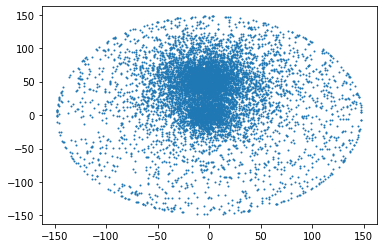

In [29]:
# Extract Dataframe
df = pd.DataFrame([vars(p) for p in points]).select_dtypes(include=["number"])
plt.scatter( df.x, df.y, s=1 )
plt.show()

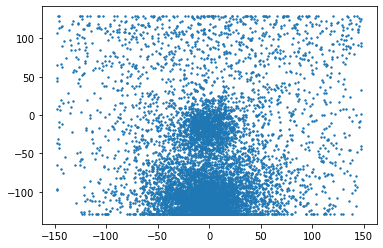

In [28]:
# Make a plot of everything
plt.scatter( df.x, df.z, s=2 )
plt.show()

In [30]:

points2 = []
    
# Grab chunks of windows from file
# for readoutwindowstep in iterate_readout_windows("my_wcsim_hitfile.root",
#                                        step_size=1000, 
#                                        max_size=30000):
    
    
for readoutwindowstep in iterate_readout_windows(get_offline_run_base(1768),
                                       step_size=1000,
                                       max_size=2000):
    
    # Grab the individual readout window from the iteration step
    for readoutwindow in tqdm(readoutwindowstep):
        
        # Iterate over n50 windows inside the window
        for n50window in iterate_n50_windows(readoutwindow,
                                             nhits_min=10,
                                             nhits_max=100):
            
            result = run_bonsai(n50window)
            points2.append(result)
            


100%|██████████| 1000/1000 [02:06<00:00,  7.93it/s]


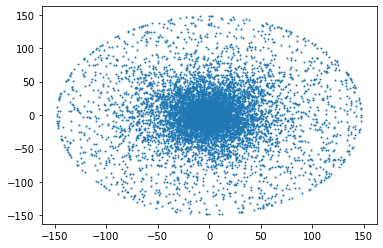

In [31]:
df = pd.DataFrame([vars(p) for p in points2]).select_dtypes(include=["number"])
plt.scatter( df.x, df.y, s=1 )
plt.show()

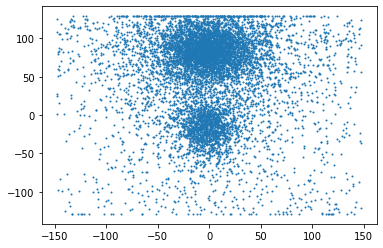

In [32]:
df = pd.DataFrame([vars(p) for p in points2]).select_dtypes(include=["number"])
plt.scatter( df.x, df.z, s=1 )
plt.show()

100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


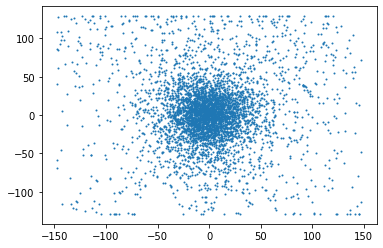

In [35]:


points3 = []
    
# Grab chunks of windows from file
# for readoutwindowstep in iterate_readout_windows("my_wcsim_hitfile.root",
#                                        step_size=1000, 
#                                        max_size=30000):
    
    
for readoutwindowstep in iterate_readout_windows(get_offline_run_base(1769),
                                       step_size=100,
                                       max_size=1000):
    
    # Grab the individual readout window from the iteration step
    for readoutwindow in tqdm(readoutwindowstep):
        
        # Iterate over n50 windows inside the window
        for n50window in iterate_n50_windows(readoutwindow,
                                             nhits_min=10,
                                             nhits_max=100):
            
            result = run_bonsai(n50window)
            points3.append(result)
            
df = pd.DataFrame([vars(p) for p in points3]).select_dtypes(include=["number"])
plt.scatter( df.x, df.z, s=1 )
plt.show()

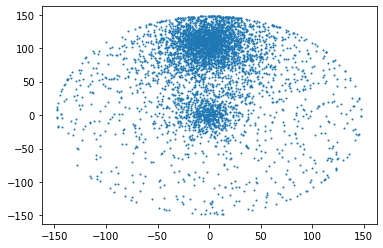

In [36]:
plt.scatter( df.x, df.y, s=1 )
plt.show()